In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image
import os
from vgg_models.vgg import vgg13_bn

# Function to divide an image into 9 patches and randomly permute them
def divide_and_permute(image):

    # Check if the image size is 32x32
    if image.shape != (3, 32, 32):
        raise ValueError("Input image must be of size 32x32x3.")

    # Divide the image into 16 non-overlapping 4x4 patches
    patches = []
    block_size = 8
    
    for row in range(0, image.shape[1], block_size):
        for col in range(0, image.shape[2], block_size):
            patch = image[:,row:row + block_size, col:col + block_size]
            patches.append(patch)
            
    
    # Randomly permute the patches
    np.random.shuffle(patches)

    # Create a new image using the permuted patches
    permuted_image = torch.zeros_like(image)

    
    for j, patch in enumerate(patches):
        row = (j // 4) * block_size
        col = (j % 4) * block_size
        permuted_image[:,row:row + block_size, col:col + block_size] = patch

    return permuted_image


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)



# Create a folder to save the modified images
output_folder = "modified_cifar_images"
os.makedirs(output_folder, exist_ok=True)

# Evaluate the model on the original CIFAR-10 test set
with torch.no_grad():
    # original_images = []
    modified_images = []
    labels = []

    for i in range(len(test_dataset)):
        image, label = test_dataset[i]
        transform = transforms.Compose([transforms.PILToTensor()])

        image = transform(image) 

        # Divide and permute the image
        modified_image = divide_and_permute(image)
        modified_images.append(Image.fromarray(modified_image.permute(1,2,0).numpy().astype(np.uint8)))
        labels.append(label)

    # Apply the transform to each image and store in a dictionary
    dataset_dict = [{'image': img, 'label': label} for img, label in zip(modified_images, labels)]

    # Save the dataset dictionary to a file
    torch.save(dataset_dict, 'cifar10_permuted.pth')
    #original_images = np.array(original_images)
    # modified_images = np.array(modified_images)

    # # Save the modified images
    # for i, modified_image in enumerate(modified_images):
        
    #     img = Image.fromarray(modified_image.astype(np.uint8))
    #     img.save(os.path.join(output_folder, f"image_{i}.png"))

    


Files already downloaded and verified


In [81]:
from IPython.display import display
from torchvision import datasets, transforms

class CustomDataset(Dataset):
    def __init__(self, dataset_dict, transform = None):
        self.dataset_dict = dataset_dict
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, index):
        data = self.dataset_dict[index]
        image = transform(data['image'])
        label = data['label']

        return image, label

# Load the dataset dictionary
loaded_dataset = torch.load('cifar10_permuted.pth')

# Create an instance of the CustomDataset
transform = transforms.ToTensor()
custom_dataset = CustomDataset(loaded_dataset, transform)

# Example: Access images and labels from the dataset
index = 0
image, label = custom_dataset[index]


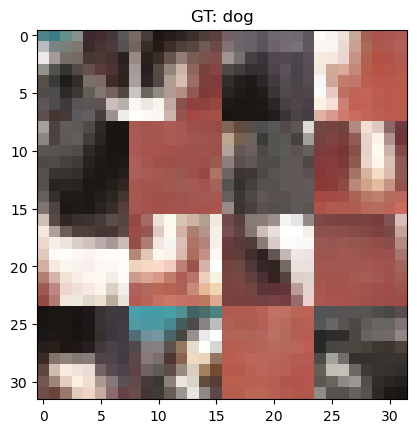

In [86]:
import matplotlib.pyplot as plt

# Function to divide an image into 4x4 blocks and randomly permute them
def show_image(ims, gt_labels, pred_labels=None):

    #ims = ims / 2 + 0.5     # unnormalize
    im_np = ims.numpy()

    plt.imshow(np.transpose(im_np, (1, 2, 0)))

    
    im_title = f'GT: {CLASSES[gt_labels]}'
    plt.title(im_title)
    plt.show()


CLASSES = ["airplane",  "car",  "bird",  "cat",  "deer",  "dog",  "frog",  "horse",  "ship", "truck"]

batch_size = 8

# Generate our data loaders
train_loader = DataLoader(custom_dataset, batch_size, shuffle=True)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


idx = 0
show_image(images[idx], labels[idx])

